# Experiment setup

## Representation Distribution

For this task, we would like to see the compressibility between auto-encoder and PCA.

## Reconstruction

For this task, we would like to show the expressivity between auto-encoder and PCA.

## Dataset

We will use MNIST and LFW

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the autoencoder model with better architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: reduce dimensionality more gracefully
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # Smaller latent space
        )
        # Decoder: mirror the encoder structure
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()  # Output normalized pixel values
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded * 2 - 1  # Rescale output to [-1, 1]


# Load the MNIST dataset with improved preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Center pixel values to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Larger batch size for efficiency

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()  # MSE is fine for reconstruction tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop with added improvements
num_epochs = 6
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # Flatten images and move to device
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training complete")

Epoch [1/6], Average Loss: 0.2359
Epoch [2/6], Average Loss: 0.1384
Epoch [3/6], Average Loss: 0.1073
Epoch [4/6], Average Loss: 0.0952
Epoch [5/6], Average Loss: 0.0891
Epoch [6/6], Average Loss: 0.0837
Training complete


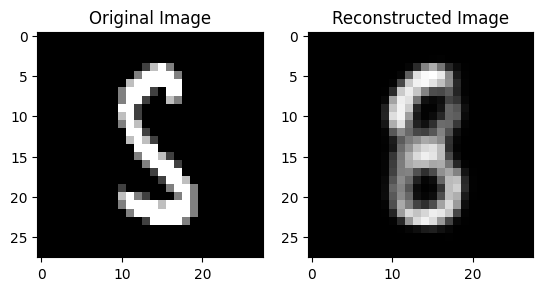

In [3]:
import matplotlib.pyplot as plt

# Get a batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select an image from the batch
img = images[0].view(1, -1)

# Get the reconstruction from the autoencoder
reconstructed_img = model(img.to(device)).view(-1, 28, 28)

# Convert the images to numpy arrays for plotting
img = img.view(28, 28).detach().numpy()
reconstructed_img = reconstructed_img.cpu().detach().view(28, 28).numpy()

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()

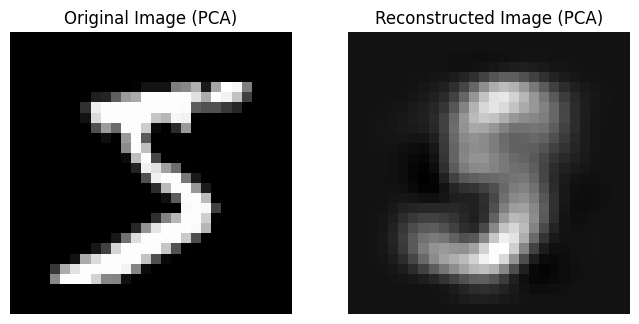

In [26]:
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transformation
transform = transforms.ToTensor()

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# Flatten all images in the training dataset
images_flat = []
for images, _ in train_loader:
    images_flat.append(images.view(images.size(0), -1).numpy())

# Combine all batches into one array
images_flat = np.vstack(images_flat)

# Apply PCA to the whole dataset
pca = PCA(n_components=10)  # Adjust components as needed
pca.fit(images_flat)
images_pca = pca.transform(images_flat)
reconstructed_images_pca = pca.inverse_transform(images_pca)

# Select an example image for comparison (first image in the dataset)
original_img_pca = images_flat[0].reshape(28, 28)
reconstructed_img_pca = reconstructed_images_pca[0].reshape(28, 28)

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_img_pca, cmap='gray')
axes[0].set_title('Original Image (PCA)')
axes[0].axis('off')
axes[1].imshow(reconstructed_img_pca, cmap='gray')
axes[1].set_title('Reconstructed Image (PCA)')
axes[1].axis('off')
plt.show()


In [5]:
!pip install nbformat


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Assuming `DataLoader`, `train_dataset`, and `model` are already defined
sampled_images, sampled_labels = next(iter(DataLoader(train_dataset, batch_size=5000, shuffle=True)))

# Flatten the images for PCA
sampled_images_flat = sampled_images.view(sampled_images.size(0), -1).numpy()

# Apply PCA to reduce dimensions to 3 for the raw image data
pca_distribution = PCA(n_components=3)
pca_embeddings = pca_distribution.fit_transform(sampled_images_flat)

# Get autoencoder embeddings
autoencoder_embeddings = model.encoder(sampled_images.view(sampled_images.size(0), -1).to(device)).cpu().detach().numpy()

# Apply PCA to reduce dimensions to 3 for the autoencoder embeddings
pca_autoencoder = PCA(n_components=3)
pca_autoencoder_embeddings = pca_autoencoder.fit_transform(autoencoder_embeddings)

# Prepare the data for Plotly
data_pca = pd.DataFrame({
    'Component 1': pca_embeddings[:, 0],
    'Component 2': pca_embeddings[:, 1],
    'Component 3': pca_embeddings[:, 2],
    'Category': sampled_labels
})

data_autoencoder = pd.DataFrame({
    'Component 1': pca_autoencoder_embeddings[:, 0],
    'Component 2': pca_autoencoder_embeddings[:, 1],
    'Component 3': pca_autoencoder_embeddings[:, 2],
    'Category': sampled_labels
})

# Create the PCA scatter plot with dropdown
def create_filtered_3d_plot(data, title):
    fig = go.Figure()

    # Add a trace for each category
    categories = data['Category'].unique()
    for category in categories:
        filtered_data = data[data['Category'] == category]
        fig.add_trace(go.Scatter3d(
            x=filtered_data['Component 1'],
            y=filtered_data['Component 2'],
            z=filtered_data['Component 3'],
            mode='markers',
            name=str(category),  # Use string for category names
            marker=dict(size=5)
        ))

    # Add dropdown menu for filtering
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        updatemenus=[
            dict(
                buttons=[
                    dict(label="All",
                         method="update",
                         args=[{"visible": [True] * len(categories)},
                               {"title": f"{title} - All Categories"}]),
                    *[
                        dict(label=str(category),
                             method="update",
                             args=[{"visible": [cat == category for cat in categories]},
                                   {"title": f"{title} - Category: {category}"}])
                        for category in categories
                    ]
                ],
                direction="down",
                showactive=True
            )
        ]
    )
    return fig

# Create plots
fig_pca = create_filtered_3d_plot(data_pca, "PCA Embeddings")
fig_pca_autoencoder = create_filtered_3d_plot(data_autoencoder, "PCA Autoencoder Embeddings")

# Show the plots
fig_pca.show()
fig_pca_autoencoder.show()


## Linear separability check

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader

# Prepare PCA and Autoencoder embeddings as datasets
pca_embeddings = pca.fit_transform(sampled_images_flat)
X_pca = torch.tensor(pca_embeddings, dtype=torch.float32)
X_autoencoder = torch.tensor(autoencoder_embeddings, dtype=torch.float32)
y = torch.tensor(sampled_labels, dtype=torch.long)

# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_train_auto, X_test_auto, _, _ = train_test_split(X_autoencoder, y, test_size=0.3, random_state=42)

# Wrap datasets in DataLoader
train_dataset_pca = TensorDataset(X_train_pca, y_train)
test_dataset_pca = TensorDataset(X_test_pca, y_test)
train_loader_pca = DataLoader(train_dataset_pca, batch_size=64, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=64, shuffle=False)

train_dataset_auto = TensorDataset(X_train_auto, y_train)
test_dataset_auto = TensorDataset(X_test_auto, y_test)
train_loader_auto = DataLoader(train_dataset_auto, batch_size=64, shuffle=True)
test_loader_auto = DataLoader(test_dataset_auto, batch_size=64, shuffle=False)

# Define a single-layer Perceptron (Logistic Regression)
class Perceptron(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

# Train and evaluate function
def train_and_evaluate(loader_train, loader_test, input_dim):
    model = Perceptron(input_dim=input_dim, num_classes=len(torch.unique(y)))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in loader_train:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Evaluate PCA embeddings
accuracy_pca = train_and_evaluate(train_loader_pca, test_loader_pca, input_dim=pca_embeddings.shape[1])
print(f'PCA Embeddings Classification Accuracy: {accuracy_pca:.4f}')

# Evaluate Autoencoder embeddings
accuracy_autoencoder = train_and_evaluate(train_loader_auto, test_loader_auto, input_dim=autoencoder_embeddings.shape[1])
print(f'Autoencoder Embeddings Classification Accuracy: {accuracy_autoencoder:.4f}')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10800\2216871393.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



PCA Embeddings Classification Accuracy: 0.7593
Autoencoder Embeddings Classification Accuracy: 0.8173


## Pairwise categorical linear separability check

In [29]:
from itertools import combinations
import numpy as np
import pandas as pd

# Function to filter dataset for two specific categories
def filter_categories(X, y, category1, category2):
    mask = (y == category1) | (y == category2)
    X_filtered = X[mask]
    y_filtered = y[mask]
    # Convert labels to binary (0 and 1) for classification
    y_filtered = (y_filtered == category2).long()
    return X_filtered, y_filtered

# Function to compute pairwise separability for given embeddings
def pairwise_separability(X, y, categories):
    results = []
    for cat1, cat2 in combinations(categories, 2):
        # Filter data for the two categories
        X_filtered, y_filtered = filter_categories(X, y, cat1, cat2)
        
        # Split data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
        
        # Define Perceptron
        model = Perceptron(input_dim=X.shape[1], num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Train the model
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train.to(device))
            loss = criterion(outputs, y_train.to(device))
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            outputs = model(X_test.to(device))
            preds = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(y_test.cpu(), preds.cpu())
        
        # Save result
        results.append((cat1, cat2, accuracy))
    
    return results

# Unique categories in the dataset
categories = torch.unique(y).tolist()

# Compute pairwise separability for PCA embeddings
results_pca = pairwise_separability(X_pca, y, categories)

# Compute pairwise separability for Autoencoder embeddings
results_auto = pairwise_separability(X_autoencoder, y, categories)

# Create tables
results_pca_table = pd.DataFrame(results_pca, columns=["Category 1", "Category 2", "Accuracy (PCA)"])
results_auto_table = pd.DataFrame(results_auto, columns=["Category 1", "Category 2", "Accuracy (Autoencoder)"])

# Combine and display
results_combined = results_pca_table.merge(results_auto_table, on=["Category 1", "Category 2"])
print(results_combined)


    Category 1  Category 2  Accuracy (PCA)  Accuracy (Autoencoder)
0            0           1        0.931818                0.990260
1            0           2        0.847518                0.411348
2            0           3        0.545455                0.909091
3            0           4        0.816609                0.930796
4            0           5        0.627240                0.322581
5            0           6        0.819444                0.309028
6            0           7        0.745981                0.987138
7            0           8        0.651408                0.933099
8            0           9        0.719178                0.643836
9            1           2        0.766234                0.737013
10           1           3        0.523220                0.696594
11           1           4        0.673016                0.958730
12           1           5        0.675410                0.967213
13           1           6        0.557325                0.69

In [30]:
# Filter pairs with >90% accuracy for PCA and Autoencoder
separable_pca = results_combined[results_combined["Accuracy (PCA)"] > 0.9]
separable_autoencoder = results_combined[results_combined["Accuracy (Autoencoder)"] > 0.9]

# Combine and show results
separable_pca["Method"] = "PCA"
separable_autoencoder["Method"] = "Autoencoder"
separable_pairs = pd.concat([separable_pca, separable_autoencoder])

# Format the output table
separable_pairs = separable_pairs.sort_values(by=["Category 1", "Category 2"]).reset_index(drop=True)
print(separable_pairs)

    Category 1  Category 2  Accuracy (PCA)  Accuracy (Autoencoder)  \
0            0           1        0.931818                0.990260   
1            0           1        0.931818                0.990260   
2            0           3        0.545455                0.909091   
3            0           4        0.816609                0.930796   
4            0           7        0.745981                0.987138   
5            0           8        0.651408                0.933099   
6            1           4        0.673016                0.958730   
7            1           5        0.675410                0.967213   
8            2           7        0.729904                0.916399   
9            3           7        0.822086                0.972393   
10           4           5        0.423077                0.933566   
11           4           6        0.501695                0.945763   
12           7           8        0.198083                0.913738   
13           8      

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10800\188386406.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10800\188386406.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## PCA as a special case of autoencoder

In [34]:
# Define the linear autoencoder model
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Linear(28 * 28, 10)  # Linear transformation to latent space
        self.decoder = nn.Linear(10, 28 * 28)  # Linear transformation back to original space

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the linear autoencoder model, loss function, and optimizer
linear_model = LinearAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop for the linear autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # Flatten images and move to device
        output = linear_model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training complete")

Epoch [1/10], Average Loss: 0.0700
Epoch [2/10], Average Loss: 0.0454
Epoch [3/10], Average Loss: 0.0389
Epoch [4/10], Average Loss: 0.0362
Epoch [5/10], Average Loss: 0.0351
Epoch [6/10], Average Loss: 0.0348
Epoch [7/10], Average Loss: 0.0347
Epoch [8/10], Average Loss: 0.0346
Epoch [9/10], Average Loss: 0.0346
Epoch [10/10], Average Loss: 0.0346
Training complete


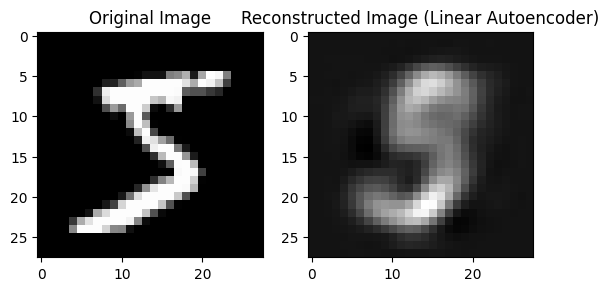

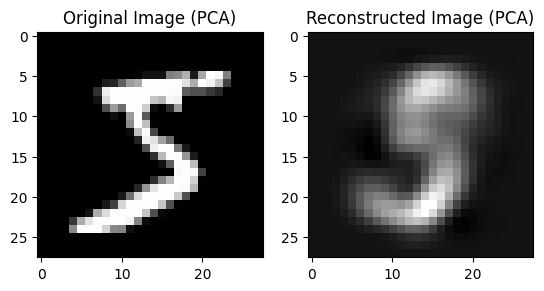

In [39]:
# Compare reconstruction error with PCA
# Get a batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select an image from the batch
img = images[0].view(1, -1)

# Get the reconstruction from the linear autoencoder
reconstructed_img_linear = linear_model(img.to(device)).view(-1, 28, 28)

# Convert the images to numpy arrays for plotting
img = img.view(28, 28).detach().numpy()
reconstructed_img_linear = reconstructed_img_linear.cpu().detach().view(28, 28).numpy()

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_img_linear, cmap='gray')
axes[1].set_title('Reconstructed Image (Linear Autoencoder)')
plt.show()


from sklearn.decomposition import PCA

# Flatten the images for PCA
images_flat = images.view(images.size(0), -1).numpy()

images_pca = pca.transform(images_flat)
reconstructed_images_pca = pca.inverse_transform(images_pca)

# Select the first image for comparison
original_img_pca = images_flat[0].reshape(28, 28)
reconstructed_img_pca = reconstructed_images_pca[0].reshape(28, 28)

# Plot the original and reconstructed images using PCA
fig, axes = plt.subplots(1, 2)
axes[0].imshow(original_img_pca, cmap='gray')
axes[0].set_title('Original Image (PCA)')
axes[1].imshow(reconstructed_img_pca, cmap='gray')
axes[1].set_title('Reconstructed Image (PCA)')
plt.show()


In [40]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error

# Sample 500 images from the dataset
sampled_images, _ = next(iter(DataLoader(train_dataset, batch_size=500, shuffle=True)))

# Flatten the images for PCA
sampled_images_flat = sampled_images.view(sampled_images.size(0), -1).numpy()

# Use PCA to reconstruct the images
images_pca = pca.transform(sampled_images_flat)
reconstructed_images_pca = pca.inverse_transform(images_pca)

# Use the Autoencoder to reconstruct the images
sampled_images_tensor = sampled_images.view(sampled_images.size(0), -1).to(device)
reconstructed_images_autoencoder = linear_model(sampled_images_tensor).cpu().detach().numpy()

# Calculate MSE loss for PCA
mse_pca = mean_squared_error(sampled_images_flat, reconstructed_images_pca)

# Calculate MSE loss for Autoencoder
mse_autoencoder = mean_squared_error(sampled_images_flat, reconstructed_images_autoencoder)

print(f'MSE Loss for PCA: {mse_pca:.6f}')
print(f'MSE Loss for Autoencoder: {mse_autoencoder:.6f}')

MSE Loss for PCA: 0.034696
MSE Loss for Autoencoder: 0.034805


## Toy dataset

In [77]:
import numpy as np

def generate_spiral(n_points=100, noise=0.1):
    theta = np.linspace(0, 2 * np.pi, n_points) + np.random.normal(0, noise, n_points)
    r = np.linspace(0.0, 1.0, n_points)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

spiral_data = generate_spiral(200)

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x

autoencoder = Autoencoder(input_dim=2, hidden_dim=50, latent_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [80]:
for epoch in range(5000):
    optimizer.zero_grad()
    inputs = torch.tensor(spiral_data, dtype=torch.float32)
    reconstructed = autoencoder(inputs)
    loss = criterion(reconstructed, inputs)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.20468473434448242
Epoch 2, Loss: 0.19399738311767578
Epoch 3, Loss: 0.1850319504737854
Epoch 4, Loss: 0.177753746509552
Epoch 5, Loss: 0.1720382273197174
Epoch 6, Loss: 0.16765068471431732
Epoch 7, Loss: 0.16428165137767792
Epoch 8, Loss: 0.16164520382881165
Epoch 9, Loss: 0.1595618575811386
Epoch 10, Loss: 0.1579592376947403
Epoch 11, Loss: 0.15682169795036316
Epoch 12, Loss: 0.15614251792430878
Epoch 13, Loss: 0.15589572489261627
Epoch 14, Loss: 0.1560242772102356
Epoch 15, Loss: 0.15643906593322754
Epoch 16, Loss: 0.15702593326568604
Epoch 17, Loss: 0.1576596200466156
Epoch 18, Loss: 0.1582227647304535
Epoch 19, Loss: 0.1586248129606247
Epoch 20, Loss: 0.15881502628326416
Epoch 21, Loss: 0.1587851196527481
Epoch 22, Loss: 0.15856243669986725
Epoch 23, Loss: 0.15819750726222992
Epoch 24, Loss: 0.1577502191066742
Epoch 25, Loss: 0.15727753937244415
Epoch 26, Loss: 0.15682481229305267
Epoch 27, Loss: 0.15642160177230835
Epoch 28, Loss: 0.15608187019824982
Epoch 29, Los

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_data = pca.fit_transform(spiral_data)

In [82]:
autoencoder_reconstructed = autoencoder(torch.tensor(spiral_data, dtype=torch.float32)).detach().numpy()
pca_reconstructed = pca.inverse_transform(pca_data)

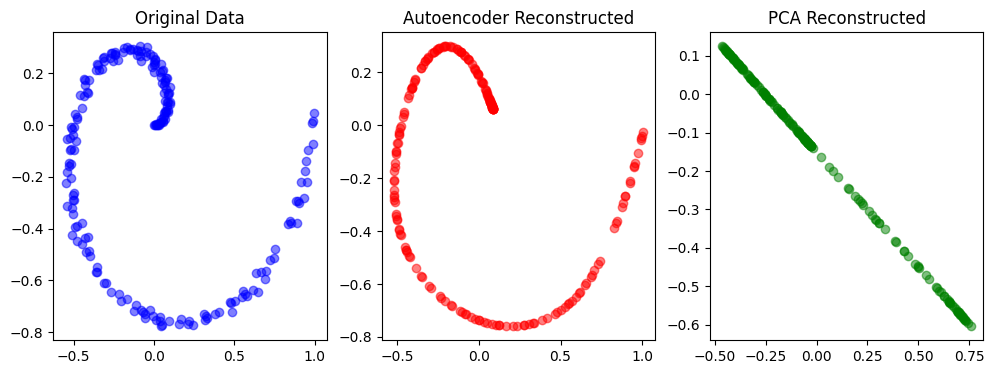

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], c='blue', alpha=0.5)
plt.title('Original Data')

plt.subplot(1, 3, 2)
plt.scatter(autoencoder_reconstructed[:, 0], autoencoder_reconstructed[:, 1], c='red', alpha=0.5)
plt.title('Autoencoder Reconstructed')

plt.subplot(1, 3, 3)
plt.scatter(pca_reconstructed[:, 0], pca_reconstructed[:, 1], c='green', alpha=0.5)
plt.title('PCA Reconstructed')

plt.show()